# U-NET

This notebook shows how to detect deadwood with U-Net, when the problem is *Semantic segmentation*.

First import, tell where the files are and make dataloaders.

In [ ]:
from fastai.vision.all import *

def label_func(fn): return f'../data/analysis_data/rasterized_vector_tiles/{fn.stem}{fn.suffix}'

fnames = [Path(f'../data/analysis_data/raster_tiles/{f}') for f in 
          os.listdir('../data/analysis_data/rasterized_vector_tiles/')]

deadwood = SegmentationDataLoaders.from_label_func('../data/analysis_data', bs=16,
                                                   fnames=fnames,
                                                   label_func=label_func,
                                                   batch_tfms= [
                                                       Normalize.from_stats(*imagenet_stats),
                                                       *aug_transforms(size=(160,160))
                                                   ])

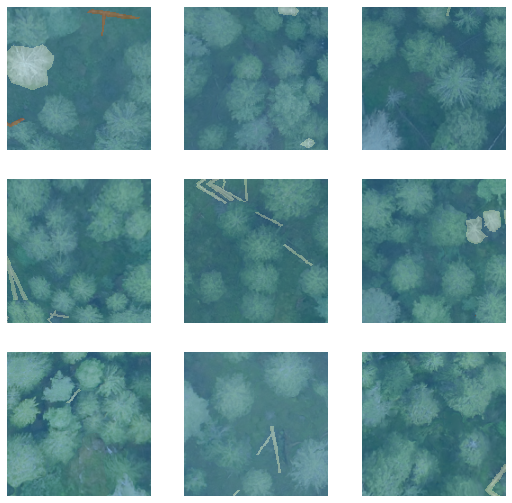

In [ ]:
deadwood.show_batch()

Create a unet_learner with pretrained resnet50 as a backbone.

In [ ]:
learn = unet_learner(deadwood, resnet50, pretrained=True, n_in=3, n_out=3, metrics=[Dice(), JaccardCoeff()]).to_fp16()

Due to memory issues, use mixed-precision training here.

Fine-tune for 1 freeze-epoch and 10 training epochs.

In [ ]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.241265,0.130567,0.814268,0.686722,00:22


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.102680,0.077293,1.312603,1.909525,00:22
1,0.096925,0.091918,1.263853,1.716850,00:22
2,0.088238,0.076192,1.361210,2.130921,00:22
3,0.081897,0.065881,1.357210,2.111438,00:22
4,0.073683,0.063425,1.345556,2.056031,00:22
5,0.069803,0.057163,1.361471,2.132200,00:22
6,0.064481,0.058037,1.330239,1.986141,00:22
7,0.060489,0.053982,1.395273,2.307278,00:22
8,0.056853,0.053770,1.418131,2.437202,00:22
9,0.055648,0.052830,1.417149,2.431407,00:22


Return to full-precision.

In [ ]:
learn.to_fp32()

See results.

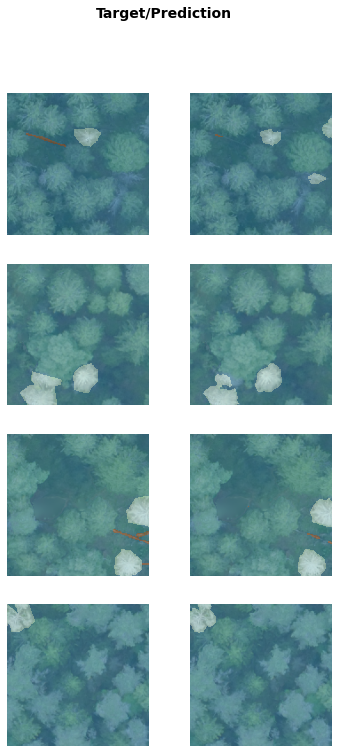

In [ ]:
learn.show_results(vmin=0, vmax=2, max_n=16)

In [ ]:
preds = learn.get_preds(with_input=True, with_decoded=True)

In [ ]:
# todo move to drone_detector.visualization?

def show_im_mask_pred(preds, max_n=4):
    ims = preds[0]
    masks = preds[2]
    preds = preds[3]
    idxs = np.random.randint(0, len(ims), max_n)
    fig, axs = plt.subplots(max_n, 3, figsize=(12, max_n*4+1))
    plt.suptitle('Image/Ground truth/prediction')
    for a in axs.flatten():
        a.set_xticks([])
        a.set_yticks([])
    for i in range(max_n):
        tempim = ims[idxs[i]].cpu().numpy().copy()
        tempim = np.moveaxis(tempim, 0, 2)
        tempim *= imagenet_stats[1]
        tempim += imagenet_stats[0]
        axs[i,0].imshow(tempim)
        tempmask = masks[idxs[i]].cpu().numpy().copy()
        tempmask = np.ma.masked_where(tempmask == 0, tempmask)
        axs[i,1].imshow(tempim)
        axs[i,1].imshow(tempmask, alpha=0.5, cmap='viridis_r')
        temppred = preds[idxs[i]].cpu().numpy().copy()
        temppred = np.ma.masked_where(temppred == 0, temppred)
        axs[i,2].imshow(tempim)
        axs[i,2].imshow(temppred, alpha=0.5, cmap='viridis_r')
    plt.tight_layout()
    return

More informative way to see predictions.

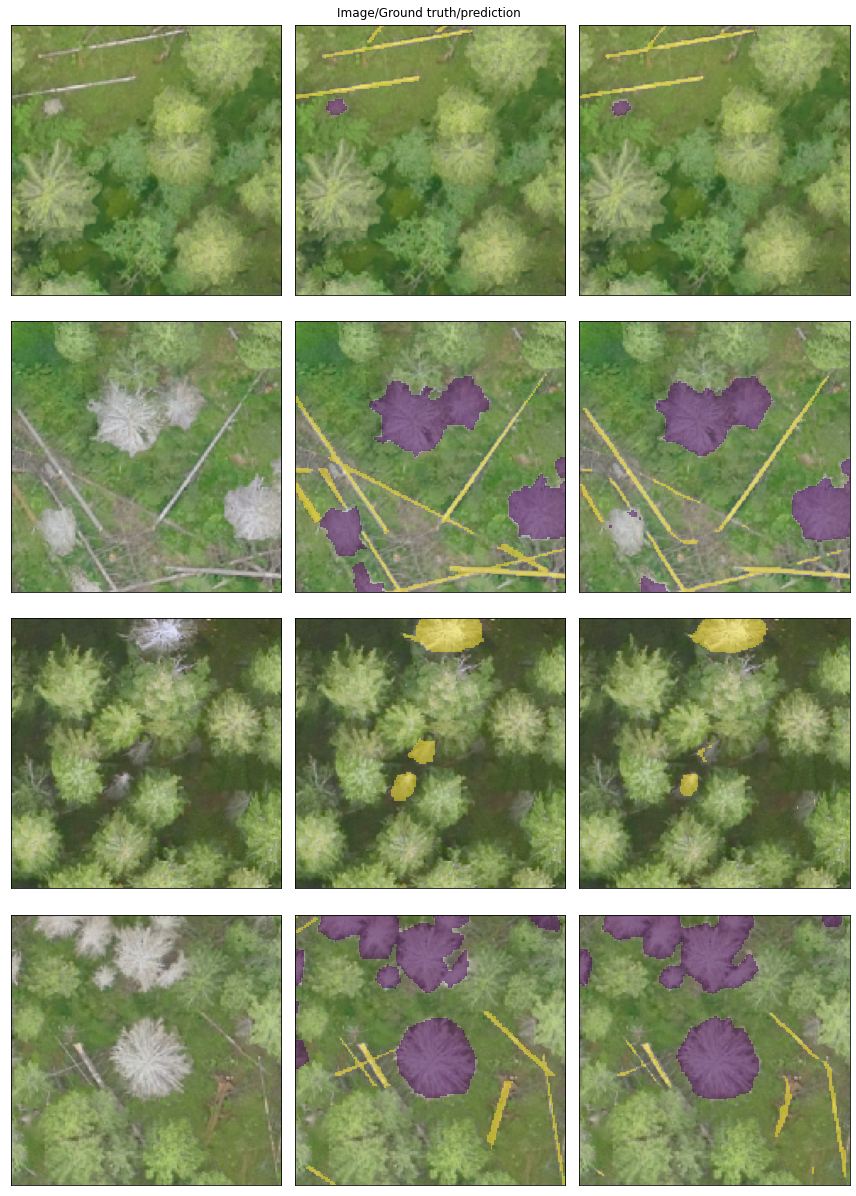

In [ ]:
show_im_mask_pred(preds, max_n=4)